<a href="https://colab.research.google.com/github/shreyasat27/pennylane-27524/blob/main/How_to_collect_statistics_of_mid_circuit_measurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Measuring qubits in the middle of a quantum circuit execution can be useful in many ways. From understanding the inner workings of a circuit, hardware characterization, modeling and error mitigation, to error correction, algorithmic improvements and even up to full computations encoded as measurements in measurement-based quantum computation (MBQC).

We will focus on extracting statistics about measurements that are performed while a quantum circuit is up and running — mid-circuit measurement statistics!

Defining the circuit ansatz

In [3]:
!pip install pennylane
import pennylane as qml
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 30.3 MB/s eta 0:00:00


In [4]:


np.random.seed(511)

first_wire =0
other_wires =[1,2,3]

def ansatz(x):
  mcms =[]

  #rotate all qubits

  for w, x_ in enumerate(x):
    qml.RX(x_, w)

  #measure first qubit
  mcms.append(qml.measure(first_wire))

  #entangle all qubits with first qubit
  for w in other_wires:
    qml.CNOT([first_wire,w])

  #measure and reset all qubits but the first
  for w in other_wires:
    mcms.append(qml.measure(w, reset=True))


  return mcms


A quantum circuit with basis MCM statistics

Before we post-process the mid-circuit measurements in this ansatz or expand the ansatz itself, let's construct a simple QNode and look at the statistics of the four performed MCMs:

1. We compute the probability vector for MCM on first qubit and, count the bit strings sampled from the other three MCMs(mid-circuit measurements)

To implement the QNode, we also define a shot-based qubit device.

In [13]:
dev = qml.device("default.qubit", shots=100)

@qml.qnode(dev)
def simple_node(x):
  #apply the ansatz, and collect mid-ircuit measurements. mcm1 is the measurement of wire 0, and mcm2 is a list of measurements of the other wires.
  mcm1, *mcm2 = ansatz(x)
  return qml.probs(op=mcm1), qml.counts(mcm2)


Before executing the ircucit, let's draw it, for this we sample some random parameters, one for each qubit and call the matplotlib to draw the circuit

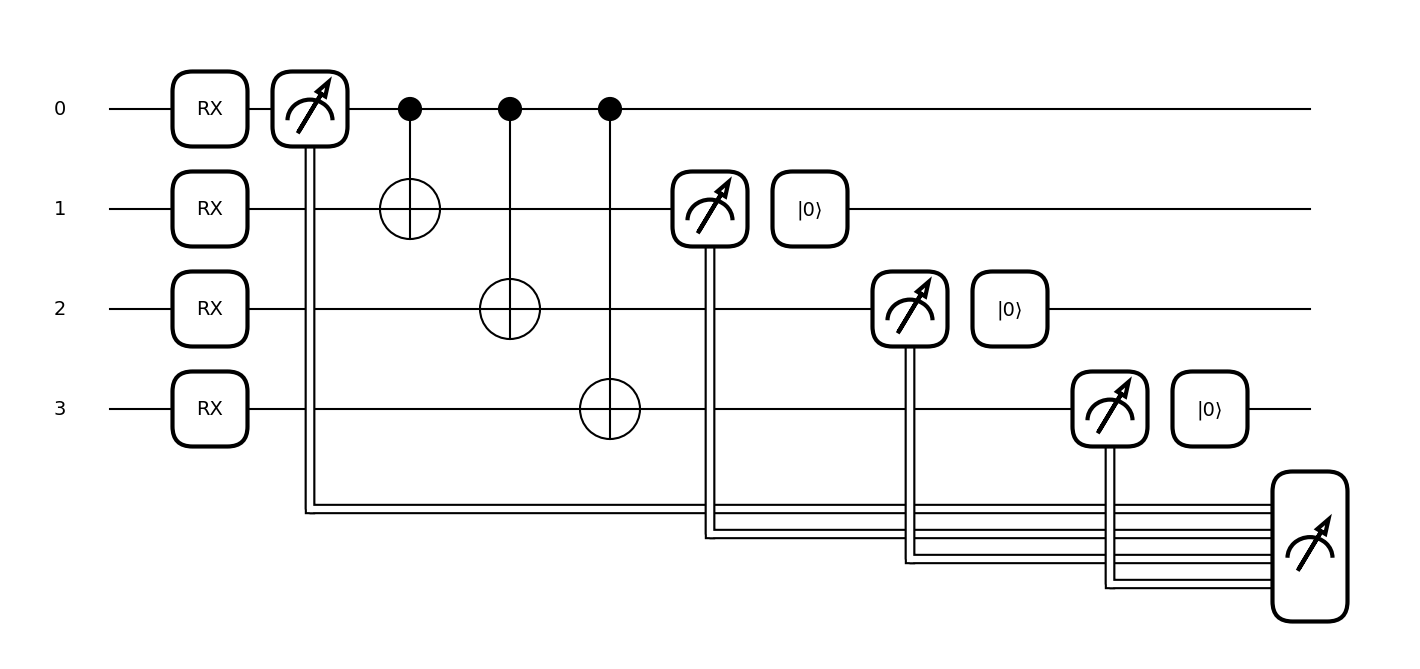

In [14]:
x = np.random.random(4)
fig, ax = qml.draw_mpl(simple_node)(x)

Let's move on to execute the circuit, now we apply the defer_measurements transform to the QNode because it allows for fast evaluation even with many shots.

In [15]:
probs, counts = qml.defer_measurements(simple_node)(x)
print(f"Probability vector of the first qubit MCM: {np.round(probs,5)}")
print(f"Bit string counts on other qubits:{counts}")

Probability vector of the first qubit MCM: [0.91 0.09]
Bit string counts on other qubits:{'000': 50, '001': 15, '010': 9, '011': 4, '100': 10, '101': 2, '110': 3, '111': 7}


Post-processing mid-circuit measurements

We now set-up a more interesting QNode, it executes the ansatz from above twice and compares the obtained MCMs (note that we did not define comparing_function yet)

Before we can run this more interesting QNode, we need to actually specify the comparing_function. We ask the following question: Is the measurement on the first qubit equal between the two sets of MCMs, and do the other three measured values summed together have the same parity, i.e. is the number of 1s odd in both sets or even in both sets?


In contrast to quantum measurements at the end of a QNode, PennyLane supports a number of unary and binary operators for MCMs even within QNodes. This enables us to phrase the question above as a boolean function. Consider the introduction on measurements and the documentation if you want to learn more about the supported operations.

In [21]:
def comparing_function(first_mcms, second_mcms):
  #a function that is comparing the two sets of MCM outcomes
  equal_first = first_mcms[0] == second_mcms[0]

  # Computing the parity can be done with the bitwise "and" operator `&`
  # with the number 1. Note that Python's and is not supported between MCMs!

  first_parity = sum(first_mcms[1:]) & 1
  second_parity = sum(second_mcms[1:]) & 1
  equal_parity = first_parity == second_parity

  return equal_first & equal_parity


In [22]:
@qml.qnode(dev)
def interesting_qnode(x):
  first_mcms = ansatz(x)
  second_mcms = ansatz(-x)
  output = comparing_function(first_mcms, second_mcms)
  return qml.counts(output)

we can draw the circuit to inspect this QNode

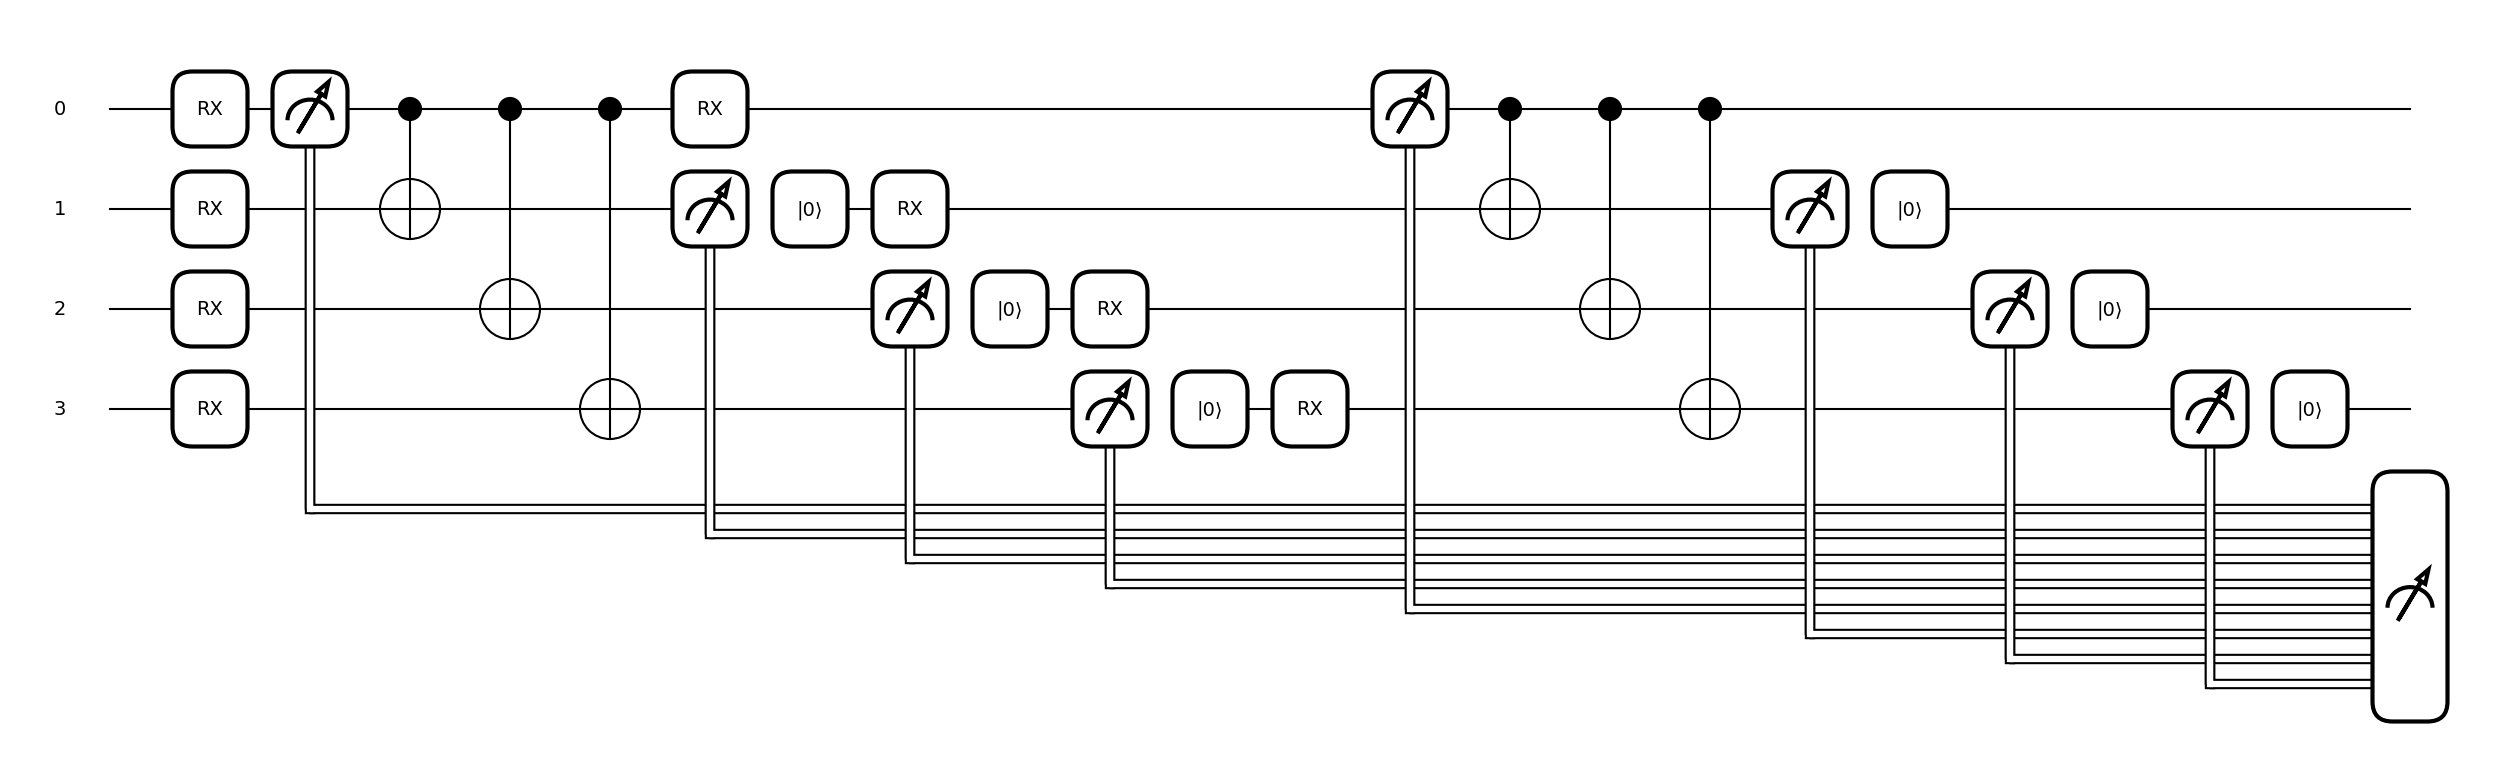

In [23]:
fig, ax = qml.draw_mpl(interesting_qnode)(x)

Note how all mid-circuit measurements feed into the classical output variable.

Finally we may run the QNode and obtain the statistics for our comparison function:



In [24]:
print(qml.defer_measurements(interesting_qnode)(x))

{False: 55, True: 45}


In [25]:
num_shots = 10000
counts = qml.defer_measurements(interesting_qnode)(x, shots=num_shots)
p_yes = counts[True] / num_shots
p_no = counts[False] / num_shots
print(f'The probability to answer with "yes" / "no" is {p_yes:.5f} / {p_no:.5f}')

The probability to answer with "yes" / "no" is 0.51160 / 0.48840


For performance considerations, take a look at defer_measurements() and dynamic_one_shot(), two simulation techniques that PennyLane uses under the hood to run circuits like the ones in this how-to.

In [26]:
probs, counts = qml.defer_measurements(simple_node)(x, shots=10000)
print(f"Bit string counts on last three qubits: {counts}")

Bit string counts on last three qubits: {'000': 5488, '001': 1168, '010': 1050, '011': 303, '100': 1031, '101': 287, '110': 279, '111': 394}


Supported MCM return types

Before finishing, we discuss the return types that are supported for (postprocessed) MCMs. Depending on the processing applied to the MCM results, not all return types are supported. qml.probs(mcm0 * mcm1), for example, is not a valid return value, because it is not clear which probabilities are being requested.

Furthermore, available return types depend on whether or not the device is shot-based (qml.sample can not be returned if the device is not sampling). Overall, all combinations of post-processing and all of
1. expval(),
2. var(),
3. probs(),
4. sample(),
5. counts(),

are supported for mid-circuit measurements with the following exceptions:

qml.sample and qml.counts are not supported for shots=None.

qml.probs is not supported for MCMs collected in arithmetic expressions.

qml.expval and qml.var are not supported for sequences of MCMs.

qml.probs, qml.sample, and qml.counts are supported for sequences but only if they do not contain arithmetic expressions of these MCMs.